In [66]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import gui
import SimpleITK as sitk
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scanpy
%matplotlib inline

In [67]:
def prep_msi_image(output_directory,msi_intensities,msi_coords,setting,peaks=None):
    fig, ax = plt.subplots(nrows=1, ncols=1 )  # create figure & 1 axis
    ax.margins(x=0,y=0)

    if setting == 'PCA_1':
        from sklearn.decomposition import PCA
        if peaks != None:
            msi_intensities = msi_intensities[peaks]
        pca = PCA(n_components=1)
        reduction = pca.fit_transform(msi_intensities)
#        plt.scatter(x=msi_coords['x'], y=msi_coords['y'], c=reduction,s=1)
#        plt.gca().invert_yaxis()
#        return(reduction)
#        fig, ax = plt.subplots()
        ax.scatter(x=msi_coords['x'], y=msi_coords['y'], c=reduction,s=20,marker='s')
#        plt.gcf().set_size_inches(np.round(msi_coords['x'].max()/10),np.round(msi_coords['y'].max()/10))
#        fig.set_size_pixels(np.round(msi_coords['x'].max()/10),np.round(msi_coords['y'].max()/10))
#        plt.scatter(x=msi_coords['x'], y=msi_coords['y'], c=reduction,s=1)
#        plt.savefig(output_directory + '/MSI_image.png')

    if setting == 'PCA_3':
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import MinMaxScaler
        if peaks != None:
            msi_intensities = msi_intensities[peaks]
        pca = PCA(n_components=3)
        reduction = pd.DataFrame(pca.fit_transform(msi_intensities))
        scaler = MinMaxScaler()
        reduction_scaled = pd.DataFrame(scaler.fit_transform(reduction), columns=reduction.columns)
        reduction_colours = list(reduction_scaled.itertuples(index=False, name=None))
        ax.scatter(x=msi_coords['x'], y=msi_coords['y'], c=reduction_colours,s=20,marker='s')
#        plt.scatter(x=msi_coords['x'], y=msi_coords['y'], c=reduction_colours,s=1)
#        plt.gca().invert_yaxis()
#        return(reduction_colours)
    
    elif setting == 'OnePeak':
        ax.scatter(x=msi_coords['x'], y=msi_coords['y'], c=msi_intensities[peaks[0]],s=20,marker='s')
#        plt.scatter(x=msi_coords['x'], y=msi_coords['y'], c=msi_intensities[peaks[0]],s=1)
#        plt.gca().invert_yaxis()
#        return(msi_intensities[peaks[0]])
        
    ax.set_axis_off()
    fig.set_size_inches(np.round(msi_coords['x'].max()/100),np.round(msi_coords['y'].max()/100))
    fig.savefig(output_directory + '/MSI_image.png', bbox_inches='tight', pad_inches=0)   # save the figure to file
    plt.close(fig)    # close the figure window


In [70]:
from pathlib import Path
from argparse import Namespace, ArgumentParser, ArgumentDefaultsHelpFormatter
from pandas import read_csv, DataFrame  # type: ignore
from numpy import ones
from skimage.io import imread,imsave  # type: ignore
def get_landmarks(he_img, if_img, num_landmarks: int):
    """Compare the two images.
    
    Parameters
    ----------
    he_path : Path
        Path to the H&E image.
    if_path : Path
        Path to the IF images.
    num_landmarks : int
        The number of landmarks to consider.
    
    Returns
    -------
    coord_df : DataFrame
        The landmark coordinates between both images.
    
    """
#    he_img = skimage.io.imread(he_path)
 #   if_img = skimage.io.imread(if_path)
#    if_img = if_path
    
    he_coords = np.ones((num_landmarks, 2))
    if_coords = np.ones((num_landmarks, 2))
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(he_img)
    axes[1].imshow(if_img, cmap="inferno")
    
    for idx in range(num_landmarks):
        for coords, axis in zip([he_coords, if_coords], axes.ravel()):
            axis.set_title("Click here")

            point = fig.ginput(1, timeout=0, mouse_add=None, mouse_stop=None)[0]
            coords[idx, :2] = point

            axis.plot(point[0], point[1],color='red')
            axis.annotate(idx, xy = (point[0], point[1]), color='red',textcoords = 'data', fontsize=15)

            plt.draw()

            axis.set_title("")
    
  
    for axis in axes.ravel():
        axis.cla()
        axis.remove()
    plt.close("all")
    
    coord_df = DataFrame()
    coord_df[["HE_col", "HE_row"]] = he_coords
    coord_df[["IF_col", "IF_row"]] = if_coords
    return coord_df


In [71]:
def do_full_mapping(output_directory: Path, 
                    msi_he_image: Path, 
                    visium_he_image: Path, 
                    num_landmarks: int,
                    msi_coords: DataFrame, 
                    visium_coords: DataFrame, 
                    msi_intensities: DataFrame, 
                    msi_option: str):
    from skimage.transform import (  # pylint: disable=no-name-in-module
    AffineTransform,
    matrix_transform,
    warp)
    msi_coords['x'] = msi_coords['x'].transform(lambda x: (x - x.min()))
    msi_coords['y'] = msi_coords['y'].transform(lambda x: (x - x.min()))
    msi_he_img = imread(msi_he_image)
    prep_msi_image(output_directory,msi_intensities,msi_coords,msi_option)
    
    visium_he_img = imread(visium_he_image)
    msi_image = imread(output_directory + '/MSI_image.png')
    msi_image_scaled = cv2.resize(msi_image,(msi_coords['x'].max(), msi_coords['y'].max()))
    landmarks_msi_he_msi = get_landmarks(msi_he_img,msi_image_scaled,num_landmarks)

    tfm_msi = AffineTransform()
    tfm_msi.estimate(landmarks_msi_he_msi.iloc[:,:2],landmarks_msi_he_msi.iloc[:,2:4])
    msi_coords['y'] = msi_coords['y'].transform(lambda x: (x.max() - x))
    new_coords_msi = pd.DataFrame(matrix_transform(
                msi_coords.iloc[:,1:3],
                tfm_msi.inverse.params))
    temp_table = pd.DataFrame({'spot_id':msi_coords['spot_id'],
                          'MSI_original_coordinate_x':msi_coords['x'],
                          'MSI_original_coordinate_y':msi_coords['y'],
                          'MSI_new_coordinate_x':new_coords_msi[0],
                          'MSI_new_coordinate_y':new_coords_msi[1]})
 #   print(msi_table)
 #   plt.scatter(x=msi_table['MSI_original_coordinate_x'], y=msi_table['MSI_original_coordinate_y'], c='b', s=1,alpha=0.2)
 #   plt.scatter(x=msi_table['MSI_new_coordinate_x'], y=msi_table['MSI_new_coordinate_y'], c='r', s=1,alpha=0.2)
 
    msi_ = imread(output_directory + '/MSI_image.png')
    landmarks_msi_he_visium_he = get_landmarks(visium_he_img,msi_he_img,num_landmarks)
    tfm_visium = AffineTransform()
    tfm_visium.estimate(landmarks_msi_he_visium_he.iloc[:,:2],landmarks_msi_he_visium_he.iloc[:,2:4])
    new_new_coords_msi = pd.DataFrame(matrix_transform(
                new_coords_msi,
                tfm_visium.inverse.params))
    msi_table = pd.DataFrame({'spot_id':msi_coords['spot_id'],
                          'MSI_original_coordinate_x':msi_coords['x'],
                          'MSI_original_coordinate_y':msi_coords['y'],
                          'MSI_middle_coordinate_x':temp_table['MSI_new_coordinate_x'],
                          'MSI_middle_coordinate_y':temp_table['MSI_new_coordinate_y'],    
                          'MSI_new_coordinate_x':new_new_coords_msi[0],
                          'MSI_new_coordinate_y':new_new_coords_msi[1]})
    rows, cols = visium_he_img.shape[:2]
    out_he_image =warp(msi_he_img, tfm_visium,output_shape=(cols,rows))

#   plt.scatter(x=msi_table['MSI_new_coordinate_x'], y=msi_table['MSI_new_coordinate_y'], c='g', s=1,alpha=0.2)

    return((msi_table,landmarks_msi_he_msi,out_he_image))


In [5]:
%matplotlib qt
msi_coords = pd.read_csv("bleod214a_metadata.csv")
#msi_coords['y'] = msi_coords['y'].apply(lambda x: msi_coords['y'].max()-x)
visium_coords = pd.read_csv('../../input_data/lung_bleo/visium/d21_bleo_4b/spatial/tissue_positions_list.csv',header=None)
msi_intensities = pd.read_csv('bleod214a_intensities.csv')
(msi_table,landmarks,out_he) = do_full_mapping("CurrentTest/","/Users/kxjl969/Downloads/bleo_d21_3/MSI_bleo_d21_4b.png","/Users/kxjl969/Downloads/bleo_d21_3/Visium_bleo_d21_4b.png",5,msi_coords,visium_coords,msi_intensities,'PCA_1')

2024-03-25 13:58:48.145 Python[12144:24965325] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


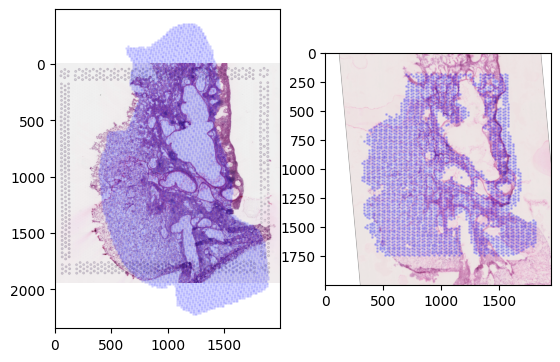

In [6]:
%matplotlib inline
plt.subplot(121)
visium_he_img = imread("/Users/kxjl969/Downloads/bleo_d21_3/Visium_bleo_d21_4b.png")
import json

f = open('../../input_data/lung_bleo/visium/d21_bleo_6b/spatial/scalefactors_json.json')
data = json.load(f)
f.close()
scale_factor = data['tissue_hires_scalef']

visium_coords = pd.read_csv('../../input_data/lung_bleo/visium/d21_bleo_4b/spatial/tissue_positions_list.csv',header=None)
msi_intensities = pd.read_csv('bleod214a_intensities.csv')
visium_included = pd.read_csv('bleod214b_visium_coords.csv')
visium_coords=visium_coords[visium_coords[0].isin(visium_included['Unnamed: 0'].tolist())]
visium_coords_df = visium_coords.iloc[:,4:6]
visium_coords_df[[4]]=visium_coords[[5]]*scale_factor
visium_coords_df[[5]]=visium_coords[[4]]*scale_factor

plt.imshow(visium_he_img)
plt.scatter(x=msi_table[['MSI_new_coordinate_x']], y=msi_table[['MSI_new_coordinate_y']], c='b', s=1,alpha=0.1)
#plt.scatter(x=visium_coords_df[4], y=visium_coords_df[5], c='r', s=1,alpha=0.2)
#plt.subplot(132)
#msi_he_img = imread("/Users/kxjl969/Downloads/bleo_d21_3/MSI_bleo_d21_4b.png")
#plt.imshow(msi_he_img)

# Opening JSON file
#plt.scatter(x=msi_table[['MSI_middle_coordinate_x']], y=msi_table[['MSI_middle_coordinate_y']], c='b', s=1,alpha=0.2)
plt.subplot(122)
plt.imshow(out_he)

plt.scatter(x=visium_coords_df[4], y=visium_coords_df[5], c='b', s=1,alpha=0.2)


In [86]:
import json
from skimage.transform import (  # pylint: disable=no-name-in-module
AffineTransform,
matrix_transform,
warp)
def do_full_mapping_frominputs(output_directory: Path, 
                    visium_path: Path, 
                    num_landmarks: int,
                    msi_coords: DataFrame, 
                    msi_intensities: DataFrame, 
                    msi_option: str,
                    msi_he_image: Path = None):

    # Prepare Visium data
    visium_obj = scanpy.read_visium(visium_path)
    visium_he_img = imread(visium_path + '/spatial/tissue_hires_image.png')
    visium_coords = pd.DataFrame(visium_obj.obsm['spatial'])
    f = open(visium_path + 'spatial/scalefactors_json.json')
    scalef = json.load(f)
    f.close()
    scale_factor = scalef['tissue_hires_scalef']

    visium_coords['x']=visium_coords[[0]]*scale_factor
    visium_coords['y']=visium_coords[[1]]*scale_factor
    visium_obj.obsm['spatial_matching']=visium.obsm['spatial']*scale_factor

    msi_coords['x'] = msi_coords['x'].transform(lambda x: (x - x.min()))
    msi_coords['y'] = msi_coords['y'].transform(lambda x: (x - x.min()))
    prep_msi_image(output_directory, msi_intensities, msi_coords, msi_option)
    msi_coords['y'] = msi_coords['y'].transform(lambda x: (x.max() - x))

    msi_image = imread(output_directory + '/MSI_image.png')
    msi_image_scaled = cv2.resize(msi_image,(msi_coords['x'].max(), msi_coords['y'].max()))

    # If we have MSI H&E then do that alignment first
    if msi_he_image != None:
            msi_he_img = imread(msi_he_image)
            landmarks_msi_he_msi = get_landmarks(msi_he_img, msi_image_scaled, num_landmarks)
            tfm_msi = AffineTransform()
            tfm_msi.estimate(landmarks_msi_he_msi.iloc[:,:2],landmarks_msi_he_msi.iloc[:,2:4])
        
            new_coords_msi = pd.DataFrame(matrix_transform(
                        msi_coords.iloc[:,1:3],
                        tfm_msi.inverse.params))
            msi_image = msi_he_img
            temp_table = pd.DataFrame({'spot_id':msi_coords['spot_id'],
                                  'MSI_original_coordinate_x':msi_coords['x'],
                                  'MSI_original_coordinate_y':msi_coords['y'],
                                  'MSI_new_coordinate_x':new_coords_msi[0],
                                  'MSI_new_coordinate_y':new_coords_msi[1]})
            #msi_coords['y'] = msi_coords['y'].transform(lambda x: (x.max() - x))
        
    else:
            msi_image = msi_image_scaled
            temp_table = pd.DataFrame({'spot_id':msi_coords['spot_id'],
                                  'MSI_original_coordinate_x':msi_coords['x'],
                                  'MSI_original_coordinate_y':msi_coords['y'],
                                  'MSI_new_coordinate_x':msi_coords['x'],
                                  'MSI_new_coordinate_y':msi_coords['x']})
            new_coords_msi = pd.DataFrame({0:msi_coords['x'],1:msi_coords['y']})
        

    landmarks_msi_he_visium_he = get_landmarks(visium_he_img, msi_image, num_landmarks)
    tfm_visium = AffineTransform()
    tfm_visium.estimate(landmarks_msi_he_visium_he.iloc[:,:2],landmarks_msi_he_visium_he.iloc[:,2:4])
    new_new_coords_msi = pd.DataFrame(matrix_transform(
                new_coords_msi,
                tfm_visium.inverse.params))
    msi_table = pd.DataFrame({'spot_id':msi_coords['spot_id'],
                          'MSI_original_coordinate_x':msi_coords['x'],
                          'MSI_original_coordinate_y':msi_coords['y'],
                          'MSI_middle_coordinate_x':temp_table['MSI_new_coordinate_x'],
                          'MSI_middle_coordinate_y':temp_table['MSI_new_coordinate_y'],    
                          'MSI_new_coordinate_x':new_new_coords_msi[0],
                          'MSI_new_coordinate_y':new_new_coords_msi[1]})
    rows, cols = visium_he_img.shape[:2]
    if msi_he_image != None:
        out_he_image =warp(msi_he_img, tfm_visium,output_shape=(cols,rows))
#        iio.imwrite(uri=output_directory+"data/warped_MSI_he.png", image=out_he_image)
    else: 
        out_he_image =warp(msi_image, tfm_visium,output_shape=(cols,rows))
#        imsave(uri=output_directory+"data/warped_MSI.png", image=out_he_image)

#   plt.scatter(x=msi_table['MSI_new_coordinate_x'], y=msi_table['MSI_new_coordinate_y'], c='g', s=1,alpha=0.2)

    return((msi_table,landmarks_msi_he_visium_he,out_he_image,visium_obj))


In [87]:
%matplotlib qt
msi_coords = pd.read_csv("bleod214a_metadata.csv")
msi_intensities = pd.read_csv('bleod214a_intensities.csv')
(msi_table,landmarks,out_he,visium_obj) = do_full_mapping_frominputs(output_directory="CurrentTest/",msi_he_image="/Users/kxjl969/Downloads/bleo_d21_3/MSI_bleo_d21_4b.png",visium_path="../../input_data/lung_bleo/visium/d21_bleo_4b/",num_landmarks=5,msi_coords=msi_coords,msi_intensities=msi_intensities,msi_option='PCA_1')
#(msi_table,landmarks,out_he) = do_full_mapping_frominputs(output_directory="CurrentTest/",msi_he_image=None,visium_path="../../input_data/lung_bleo/visium/d21_bleo_4b/",num_landmarks=5,msi_coords=msi_coords,msi_intensities=msi_intensities,msi_option='PCA_1')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


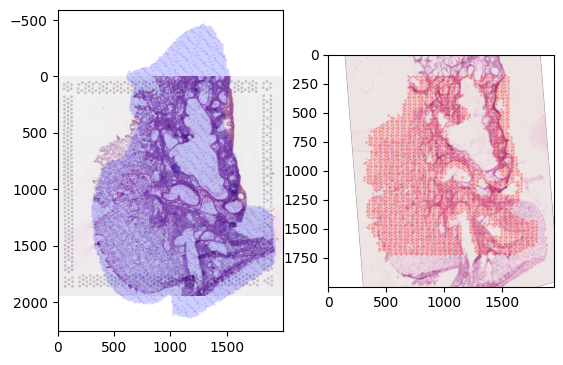

In [96]:
%matplotlib inline
plt.subplot(121)
visium_coords = pd.DataFrame(visium_obj.obsm['spatial_matching'])
#plt.imshow(visium_he_img)
visium_he_img = imread("../../input_data/lung_bleo/visium/d21_bleo_4b/spatial/tissue_hires_image.png")
plt.imshow(visium_he_img)
#scanpy.pl.spatial(visium_obj)
plt.scatter(x=msi_table[['MSI_new_coordinate_x']], y=msi_table[['MSI_new_coordinate_y']], c='b', s=1,alpha=0.1)
#plt.scatter(x=visium_coords_df[4], y=visium_coords_df[5], c='r', s=1,alpha=0.2)
#plt.subplot(132)
#msi_he_img = imread("/Users/kxjl969/Downloads/bleo_d21_3/MSI_bleo_d21_4b.png")
#plt.imshow(msi_he_img)

# Opening JSON file
#plt.scatter(x=msi_table[['MSI_middle_coordinate_x']], y=msi_table[['MSI_middle_coordinate_y']], c='b', s=1,alpha=0.2)
plt.subplot(122)
plt.imshow(out_he)

plt.scatter(x=visium_coords[[0]], y=visium_coords[[1]], c='r', s=1,alpha=0.2)


In [85]:
visium.obsm['spatial']*scale_factor

array([[1085.18629491, 1631.78313796],
       [1491.22262457, 1740.06770525],
       [1463.75111319,  550.29256208],
       ...,
       [ 615.95317   , 1707.79175914],
       [ 824.638104  ,  798.89126149],
       [1446.62761506, 1372.22047213]])

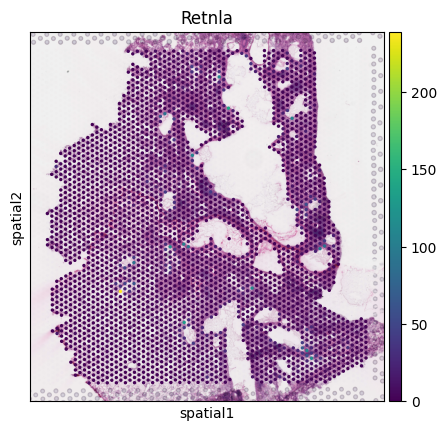

In [92]:
%matplotlib inline
scanpy.pl.spatial(visium,color='Retnla')